# IOD_lifecycle: temporal evolution of SST anomalies in the central equatorial Pacific
Computes the temporal root mean square error (RMSE) of the Dipole Mode Index (gradient between the western equatorial Indian Ocean (50E-70E and 10S-10N) and the south eastern equatorial Indian Ocean (90E-110E and 10S-0N)) between model and observations. The analysis spans 6 years centred on IOD peak years to evaluate the ability of the model to capture the full lifecycle of IOD events, including onset, peak, and sepay phases.

# Datasets Used for Temporal Evolution Comparison¶
The following reference datasets are employed to evaluate the IOD lifecycle in model simulations:

TropFlux (1979–2018): The primary dataset for comparison, offering accurate surface fluxes and anomalies for tropical climate studies.
Additional datasets include:
20CRv2 (1871–2012): A historical reanalysis dataset reconstructing global atmospheric conditions using surface pressure observations.
ERA-Interim (1979–2018): A widely used reanalysis product providing consistent, high-resolution estimates of atmospheric and surface variables.
ERSSTv5 (1854–2018): A globally gridded SST anomaly dataset optimised for long-term climate monitoring and iod analysis.
HadISST (1870–2018): A comprehensive dataset of SST and sea ice, blending historical observations with reconstructions.
NCEP2 (1979–2018): A second-generation reanalysis dataset delivering improved global atmospheric and surface data.

In [1]:
from esmvalcore.dataset import Dataset

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/myproxy/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').declare_namespace(__name__)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/pkg_resources/__init__.py:3117: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('logilab')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/pkg_resources/__init__.py:3117: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is pr

In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19780101/20190101", ##rolling window
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}
model_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

In [3]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/esmvalcore/preprocessor/_io.py:265: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  calendar_index = int(


In [4]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import xarray as xr
import sacpy as scp
from esmvalcore.iris_helpers import date2num 
# [d for d in t_coord.units.num2date(t_coord.points)]

In [20]:
def sst_iod_dmi(cube):

    iod_east = {"start_longitude": 90., "end_longitude": 110., "start_latitude": -10., "end_latitude": 0.}
    iod_west = {"start_longitude": 50., "end_longitude": 70., "start_latitude": -10., "end_latitude": 10.}
    # cube = regrid(cube, target_grid="1x1", scheme="linear")


    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land")
    cube_west = extract_region(cube, **iod_west)
    cube_east = extract_region(cube, **iod_east)

    # remove seasonal cycle
    cube_west = anomalies(cube_west, period='monthly')
    cube_east = anomalies(cube_east, period='monthly')
    #detrend
    cube_west = rolling_window_statistics(cube_west, coordinate='time',operator='mean', window_length=5)
    cube_west = rolling_window_statistics(cube_west, coordinate='time',operator='mean', window_length=5)

    cube_east = rolling_window_statistics(cube_east, coordinate='time',operator='mean', window_length=5)
    cube_east = rolling_window_statistics(cube_east, coordinate='time',operator='mean', window_length=5)

    cube_west = area_statistics(cube_west, operator='mean')
    cube_east = area_statistics(cube_east, operator='mean')
    
 
    cube_dmi = cube_west - cube_east

    return cube_dmi


def sst_meridional(cube): ##along latitude for area
    iod_trop = {"start_longitude": 50., "end_longitude": 110., "start_latitude": -10., "end_latitude": 10.}
    cube = convert_units(cube, units="degC")
    #mask
    cube = anomalies(cube, period='monthly')
    cube = extract_region(cube, **iod_trop)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = meridional_statistics(cube,operator='mean')
    return cube

#rmse

In [21]:
model_datasets_prep1 = {name: sst_iod_dmi(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep2 = {name: sst_meridional(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1 = {name: sst_iod_dmi(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep2 = {name: sst_meridional(dataset) for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully d

# Diagnostic Level 1
The first level shows the diagnostic used to compute the metric and highlight the main differences between the model and the reference.

In [24]:
def sst_regressed(dmi_sep, dmi, dmi_area):
    leadlagyr = 3 #rolling window cut off, not include first year
    dmi_sep_ct = dmi_sep[leadlagyr:-leadlagyr]
    event_years = dmi_sep_ct.time.dt.year #
    # Ensure that the selected years are not the last or second last year in the dmi dataset
    years_of_interest_array = []
    
    # Fill the array with the years of interest for each event year 
    for i, year in enumerate(event_years):# 2:-3 for sep        
        years_of_interest_array.append([year.values - 2, year.values - 1, year.values, year.values + 1, year.values + 2, year.values + 3])
    
    dmi_selected = []
    dmi_area_selected = []
    for i in range(len(years_of_interest_array)): #creates sst_time_series
        # Select the data for the current year and append it to dmi_selected #dmi is not sep month only
        dmi_selected.append(dmi.sel(time=dmi['time.year'].isin(years_of_interest_array[i])))
        dmi_area_selected.append(dmi_area.sel(time=dmi_area['time.year'].isin(years_of_interest_array[i])))

    # 1) linear regression of sst_time_series on sst_iod
    slope = scp.LinReg(dmi_sep_ct.values, dmi_selected).slope
    slope_area = scp.LinReg(dmi_sep_ct.values, dmi_area_selected).slope

    return slope, slope_area

In [29]:
model_dmi = model_datasets_prep1["ACCESS-ESM1-5"]
model_dmi_sep = extract_month(model_datasets_prep1["ACCESS-ESM1-5"],9)
model_dmi_area = model_datasets_prep2["ACCESS-ESM1-5"]

obs_dmi = obs_datasets_prep1["HadISST"]
obs_dmi_sep = extract_month(obs_datasets_prep1["HadISST"],9)
obs_dmi_area = obs_datasets_prep2["HadISST"]



In [30]:
## metric computation - rmse of slopes
cb_out = {'dmi':model_dmi, 'dmi_sep':model_dmi_sep, 'dmi_area':model_dmi_area}
darray_dict = {cbname: xr.DataArray.from_iris(cb) for cbname, cb in cb_out.items()}
model = sst_regressed(darray_dict['dmi_sep'], darray_dict['dmi'], darray_dict['dmi_area'])
## obs
cb_out = {'dmi':obs_dmi, 'dmi_sep':obs_dmi_sep, 'dmi_area':obs_dmi_area}
darray_dict = {cbname: xr.DataArray.from_iris(cb) for cbname, cb in cb_out.items()}
obs = sst_regressed(darray_dict['dmi_sep'], darray_dict['dmi'], darray_dict['dmi_area'])

rmse = np.sqrt(np.mean((obs[0] - model[0]) ** 2))
rmse




<xarray.DataArray (time: 36)> Size: 144B
[36 values with dtype=float32]
Coordinates:
  * time          (time) datetime64[ns] 288B 1978-09-16 ... 2013-09-16
    month_number  (time) int64 288B ...
Attributes: (12/45)
    units:                  degC
    physics_index:          1
    external_variables:     areacello
    table_id:               Omon
    parent_experiment_id:   piControl
    title:                  ACCESS-ESM1-5 output prepared for CMIP6
    ...                     ...
    branch_method:          standard
    table_info:             Creation Date:(30 April 2019) MD5:e14f55f257cceaf...
    forcing_index:          1
    parent_mip_era:         CMIP6
    parent_activity_id:     CMIP
    version:                v20191115
<xarray.DataArray (time: 151)> Size: 604B
[151 values with dtype=float32]
Coordinates:
  * time          (time) datetime64[ns] 1kB 1870-09-16 1871-09-16 ... 2020-09-16
    month_number  (time) int64 1kB ...
Attributes:
    units:        degC
    reference:   

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/sacpy/linger_cal.py:45: RuntimeWarning: invalid value encountered in sqrt
  t = corr / (np.sqrt(1 - corr**2) + EPS) * np.sqrt(Num0 - 2)


0.23932907

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


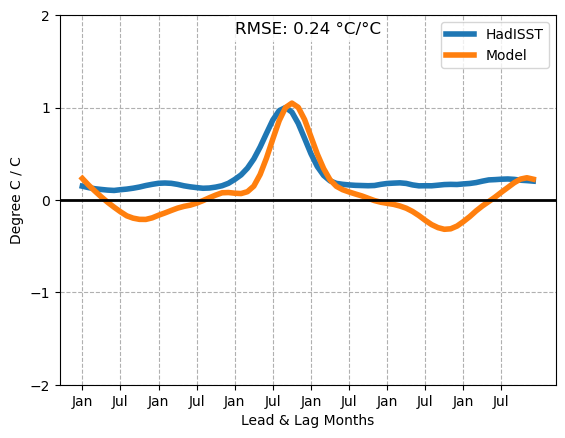

In [31]:
months = np.arange(1, 73) - 36

# Plot the slope
plt.plot(months, obs[0], label='HadISST', lw=4)
plt.plot(months, model[0], label='Model', lw=4)

# Draw a black dashed line at y=0.25
# plt.axhline(y=0.25, color='black', linestyle='--', label='0.25 threshold')

# Draw a thicker line at y=0
plt.axhline(y=0, color='black', linewidth=2) #, label='Zero Line')

# Define custom ticks for the x-axis (every 6 months)
xticks = np.arange(1, 73, 6) - 36  # Adjust for lead/lag months
xtick_labels = ['Jan', 'Jul'] * (len(xticks) // 2)

# Set the labels and titles
plt.xlabel('Lead & Lag Months')
plt.ylabel('Degree C / C')
plt.legend()
plt.grid(linestyle='--')

# Apply the custom ticks and labels to the x-axis
plt.xticks(xticks, xtick_labels)
plt.yticks(np.arange(-2,2.5, step=1))

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} °C/°C', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
# Show the plot
plt.show()

Figure 1: Temporal evolution of DMI, illustrating the IOD-associated variability. The model tends to exhibit overly frequent transitions between negative and positive SSTA phases. The black curve represents the reference data, while the blue curve corresponds to the model output. The derived metric is the temporal root mean square error (RMSE) between the model and reference curves.

# Diagnostic Level 2
The second level shows the broader picture to better understand the spatial-temporal pattern of IOD: the Hovmöller of the anomalies in the equatorial Indian Ocean.

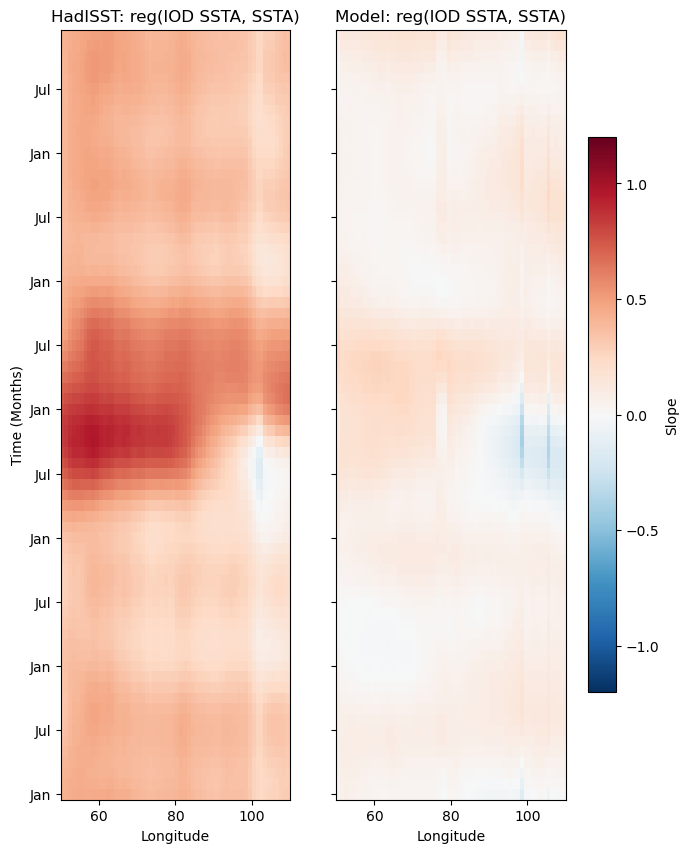

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom ticks for the y-axis (every 6 months)
yticks = range(1, 73, 6)
ytick_labels = ['Jan', 'Jul'] * (len(yticks) // 2)

# Define shared color limits for both subplots
vmin = -1.2 # min(np.min(slope_area), np.min(obs_slope_area))
vmax = 1.2 # max(np.max(slope_area), np.max(obs_slope_area))

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 10), sharey=True)

# First subplot obs[0] - model[0]
c1 = ax1.pcolormesh(obs_dmi_area.coord('longitude').points, range(1, 73), obs[1], shading='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax1.set_ylabel('Time (Months)')
ax1.set_xlabel('Longitude')
ax1.set_xlim([50,110])
ax1.set_title('HadISST: reg(IOD SSTA, SSTA)')
ax1.set_yticks(yticks)
ax1.set_yticklabels(ytick_labels)

# Second subplot
c2 = ax2.pcolormesh(model_dmi_area.coord('longitude').points, range(1, 73), model[1], shading='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Longitude')
ax2.set_title('Model: reg(IOD SSTA, SSTA)')
ax2.set_xlim([50,110])

# Adjust the layout to add more space for the colorbar on the right
plt.subplots_adjust(right=1.05)

# Add a colorbar and position it slightly to the right of the plots
cbar = fig.colorbar(c1, ax=[ax1, ax2], label='Slope', orientation='vertical', fraction=0.05, pad=0.04)

# Display the plot
# plt.tight_layout()
#plt.show()


Figure 2: spatial-temporal structure of SSTas in the equatorial Indian Ocean (10°S-10°N average), showing usually the too frequent swing from negative to positive SSTA, along with maximum anomalies during iod peak lasting too long. The left and right Hovmöllers show respectively the reference and the model.